In [1]:
import numpy as np
import uproot as up
import utils
from matplotlib import pyplot as plt
plt.rcParams.update({"figure.facecolor" : "white",
                    "figure.dpi" : 90})
from scipy.linalg import cholesky, sqrtm
from scipy.optimize import minimize
from scipy.stats import norm, rv_histogram

In [2]:
# Data, pre and post fit from Jaafar
F = up.open("T2K_fit/chi2_T2K_CC0pi0p.root")
unfolded_h = F["hist_data_cc0pi0p"].to_numpy()
bins = unfolded_h[1]
pre_fit_h = F["hist_mc_cc0pi0p_prefit"].to_numpy()
post_fit_h = F["hist_mc_cc0pi0p_postfit"].to_numpy()

In [3]:
# Bin meanings
costheta_edges = [-1.0, -0.3, 0.3, 0.6, 0.7, 0.8, 0.85, 0.9, 0.94, 0.98, 1.0]
pmu_edges = [
    [0., 30.],
    [0., 0.3, 0.4, 30.],
    [0., 0.3, 0.4, 0.5, 0.6, 30.],
    [0., 0.3, 0.4, 0.5, 0.6, 30.],
    [0., 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 30.],
    [0., 0.4, 0.5, 0.6, 0.7, 0.8, 30.],
    [0., 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 30.],
    [0., 0.4, 0.5, 0.6, 0.7, 0.8, 1.25, 30.],
    [0., 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.25, 1.5, 2.0, 30.],
    [0., 0.5, 0.65, 0.8, 1.25, 2.0, 3.0, 5.0, 30.],
]
# i -> costheta_min, costheta_max, pmu_min, pmu_max
bin_edges = []
for ic in range(len(costheta_edges) - 1):
    for ip in range(len(pmu_edges[ic]) -1):
        bin_edges.append( (costheta_edges[ic], costheta_edges[ic+1], pmu_edges[ic][ip], pmu_edges[ic][ip+1]) )

Text(0.5, 0, 'bin')

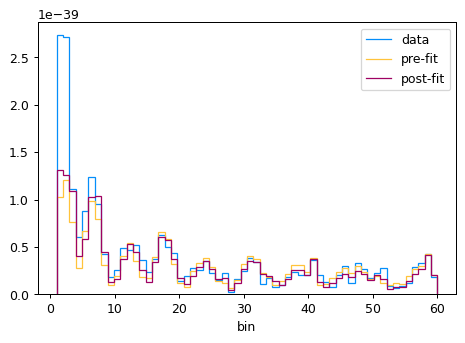

In [4]:
plt.stairs(*unfolded_h, label="data")
plt.stairs(*pre_fit_h, label="pre-fit")
plt.stairs(*post_fit_h, label="post-fit")
plt.legend()
plt.xlabel("bin")

In [5]:
# Error bars
F = up.open("T2K_fit/chi2_T2K_CC0pi0p.root")
cov_unfolded = F["cov_cc0pi0p"].to_numpy()[0]
cor_unfolded = cov_unfolded / (
    np.sqrt(np.diag(cov_unfolded))[:, None] * np.sqrt(np.diag(cov_unfolded))[None, :]
)
cov_unfolded_inv = np.linalg.inv(cov_unfolded)
cor_unfolded[~np.isfinite(cor_unfolded)] = 0

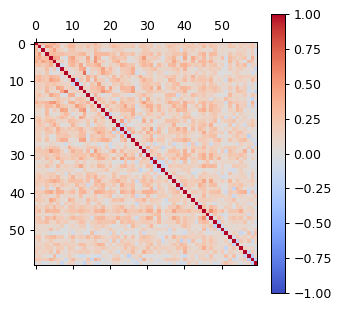

In [6]:
plt.matshow(cor_unfolded, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

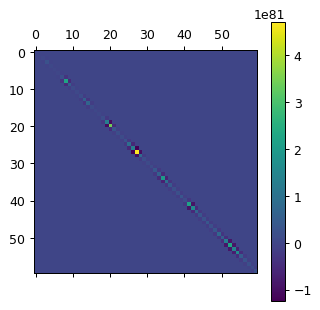

In [7]:
# Regularisation
C = utils.Q1s(pre_fit_h[0]) * 1e80
plt.matshow(C)
plt.colorbar()

In [8]:
# Regularised result
#
# m' = A m
# A = (cov^{-1} + C)^-1 cov^{-1}

diff = unfolded_h[0] - pre_fit_h[0]
chi2 = diff.T @ cov_unfolded_inv @ diff
tau_inv = pre_fit_h[0].T @ C @ pre_fit_h[0]
tau_max = chi2 / tau_inv
print(chi2, tau_inv, tau_max)

tau_list = [0.0] + list(np.logspace(-1, 0, 9))
A_list = [
    np.linalg.inv(cov_unfolded_inv + tau * C) @ cov_unfolded_inv for tau in tau_list
]
regularised_list = [A @ unfolded_h[0] for A in A_list]

193.20283821532317 2.5768113047873383e-14 7497748781852228.0


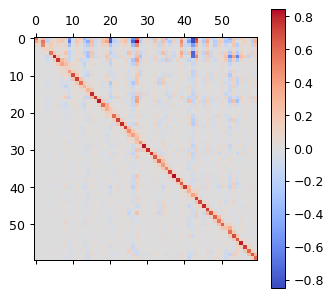

In [9]:
plt.matshow(A_list[-1], cmap="coolwarm", vmin=-np.max(A_list[-1]))
plt.colorbar()

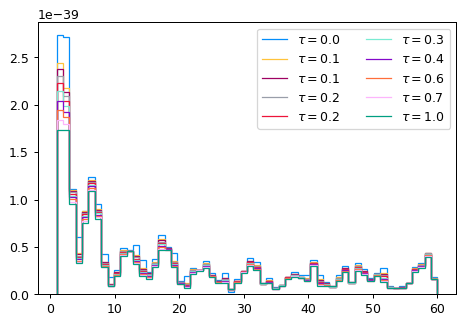

In [10]:
for x, tau in zip(regularised_list, tau_list):
    plt.stairs(x, bins, label=rf"$\tau = {tau:3.1f}$")
plt.legend(ncol=2)

In [11]:
# Metrics
jaggedness = [x.T @ C @ x for x in regularised_list]
bias = [
    (x - unfolded_h[0]).T @ cov_unfolded_inv @ (x - unfolded_h[0])
    for x in regularised_list
]

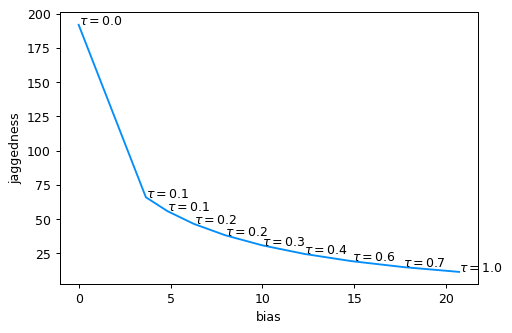

In [12]:
plt.plot(bias, jaggedness)
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(bias, jaggedness, tau_list):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))

In [13]:
# Alt metrics
# Determinant of covariance/correlation matrix as measure of overall correlation?
cov_list = [A @ cov_unfolded @ A.T for A in A_list]
cor_list = [
    np.diag(np.diag(cov) ** (-0.5)) @ cov @ np.diag(np.diag(cov) ** (-0.5))
    for cov in cov_list
]
cov_det_list = [np.linalg.det(cov) for cov in cov_list]
cor_det_list = [np.linalg.det(cor) for cor in cor_list]

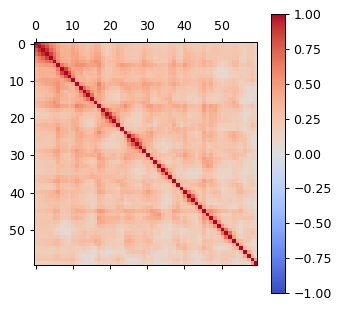

In [14]:
plt.matshow(cor_list[-1], cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [15]:
# Alt metrics
# Wasserstein distance in uncorrelated standard normal space
# The Fréchet distance between multivariate normal distributions
# https://doi.org/10.1016/0047-259X(82)90077-X
dist = []
diag_dist = []


def wasserstein(x, cov, base_x=unfolded_h[0], base_cov=cov_unfolded):
    U = cholesky(np.linalg.inv(base_cov))
    m = U @ base_x
    diff = m - U @ x
    S = U @ cov @ U.T
    d = diff.T @ diff + cov.shape[0] + np.trace(S - 2 * sqrtm(S))
    return abs(d)  # Catch some numerical issues


for x, cov in zip(regularised_list, cov_list):
    # Distance between original and regularised
    dist.append(wasserstein(x, cov))
    # Distance between original and plot
    diag_dist.append(wasserstein(x, np.diag(np.diag(cov))))

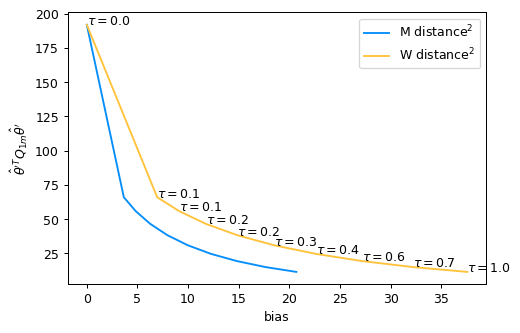

In [16]:
plt.plot(bias, jaggedness, label="M distance$^2$")
plt.plot(dist, jaggedness, label="W distance$^2$")
plt.legend()
plt.xlabel("bias")
plt.ylabel(r"${\hat\theta}'^T Q_{1m} {\hat\theta}'$")
for x, y, tau in zip(dist, jaggedness, tau_list):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))

4 0.23713737056616552 30.372355050634532 5.511111961359026


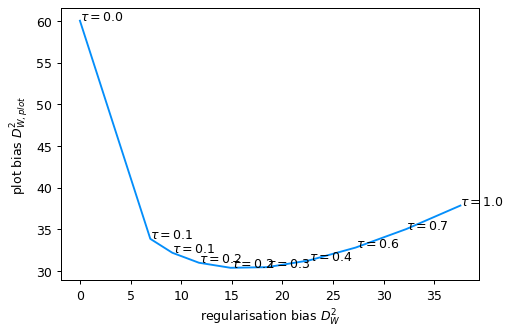

In [17]:
plt.plot(dist, diag_dist)
plt.xlabel("regularisation bias $D^2_W$")
plt.ylabel("plot bias $D^2_{W,plot}$")
i_W = 0
best = np.inf
for i, (x, y, tau) in enumerate(zip(dist, diag_dist, tau_list)):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))
    if y < best:
        best = y
        i_W = i
print(i_W, tau_list[i_W], best, np.sqrt(best))

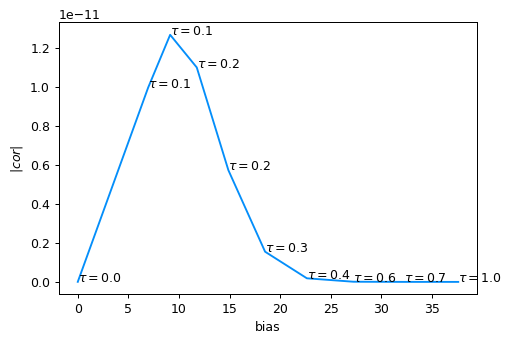

In [18]:
plt.plot(dist, cor_det_list)
plt.xlabel("bias")
plt.ylabel(r"$|cor|$")
i_D = 0
best = 0
for i, (x, y, tau) in enumerate(zip(dist, cor_det_list, tau_list)):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))
    if y > best:
        best = y
        i_D = i

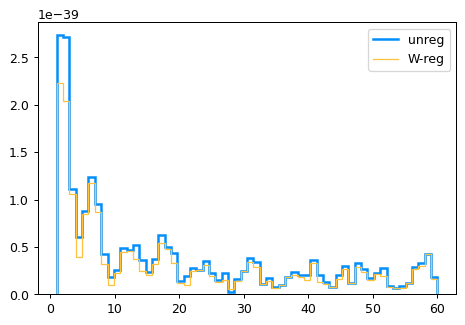

In [19]:
plt.stairs(*unfolded_h, label="unreg", linewidth=2)
plt.stairs(regularised_list[i_W], bins, label="W-reg")
plt.legend()

In [20]:
# Minimal possible plot bias
def fun(x):
    return wasserstein(unfolded_h[0], np.diag(x))


ret = minimize(fun, x0=np.diag(cov_unfolded))
best_error = np.sqrt(ret.x)

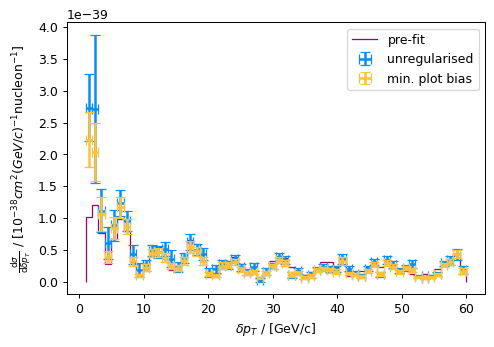

In [21]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = unfolded_h[0]
yerr = np.sqrt(np.diag(cov_unfolded))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="unregularised",
    linewidth=2,
    linestyle="",
    capsize=4,
)

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="min. plot bias",
    linewidth=2,
    linestyle="",
    capsize=4,
)

# y = unfolded_h[0]
# yerr = best_error
# plt.errorbar(
#    x, y, yerr=yerr, xerr=xerr, label="best possible", linewidth=1, linestyle="", capsize=4
# )

plt.stairs(*pre_fit_h, label="pre-fit")
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ [10^{-38} cm^2 (GeV/c)^{-1} \mathrm{nucleon}^{-1}]$"
)
plt.legend()

-1.0975435349863492 85.3341904835164


Text(0, 0.5, '$\\frac{\\mathrm{d}\\sigma}{\\mathrm{d}\\delta p_T}\\ /\\ \\frac{\\mathrm{d}\\sigma_\\mathrm{MC,pre-fit}}{\\mathrm{d}\\delta p_T}$')

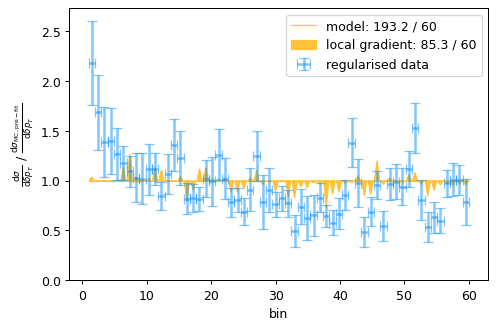

In [22]:
utils.model_ratio_plot(
    pre_fit_h[0], regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="regularised data"
)
plt.xlabel(r"bin")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,pre-fit}}{\mathrm{d}\delta p_T}$"
)

-0.5677777232009288 46.043395007222315


Text(0, 0.5, '$\\frac{\\mathrm{d}\\sigma}{\\mathrm{d}\\delta p_T}\\ /\\ \\frac{\\mathrm{d}\\sigma_\\mathrm{MC,post-fit}}{\\mathrm{d}\\delta p_T}$')

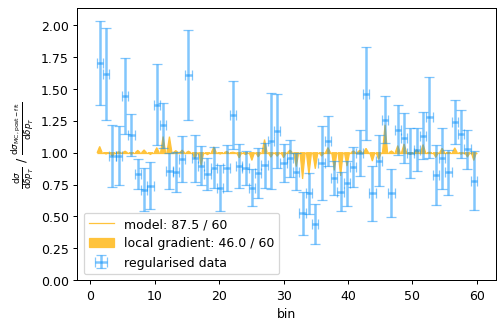

In [23]:
utils.model_ratio_plot(
    post_fit_h[0], regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="regularised data"
    #post_fit_h[0], regularised_list[0], cov_list[0], A_list[0], bins=bins, data_label="regularised data"
)
plt.xlabel(r"bin")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,post-fit}}{\mathrm{d}\delta p_T}$"
)

-0.5677777232009288 46.043395007222315


Text(0, 0.5, '$\\Delta D^2_M$')

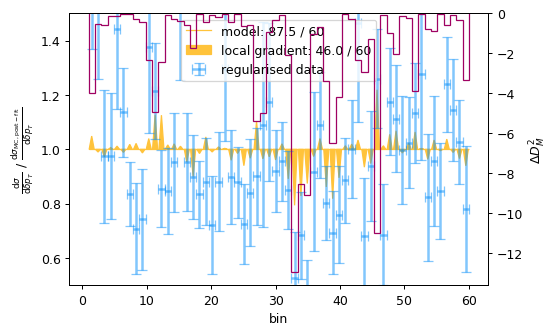

In [24]:
grad = utils.model_ratio_plot(
    post_fit_h[0], regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="regularised data"
)
plt.xlabel(r"bin")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,post-fit}}{\mathrm{d}\delta p_T}$"
)
plt.ylim(0.5,1.5)

ax = plt.twinx()

# N-1 plots
orig_chi2 = utils.chi2(post_fit_h[0], unfolded_h[0], cov_unfolded_inv)
mod_chi2 = []
for i in range(len(unfolded_h[0])):
    d = np.delete(unfolded_h[0], i)
    m = np.delete(post_fit_h[0], i)
    c = np.delete(cov_unfolded, i, axis=0)
    c = np.delete(c, i, axis=1)
    ci = np.linalg.inv(c)
    mod_chi2.append(utils.chi2(m, d, ci))
mod_chi2 = np.array(mod_chi2)

ax.stairs(mod_chi2 - orig_chi2, bins, color="C2")
ax.set_ylabel(r"$\Delta D^2_M$")

Text(0, 0.5, '$\\Delta D^2_M$')

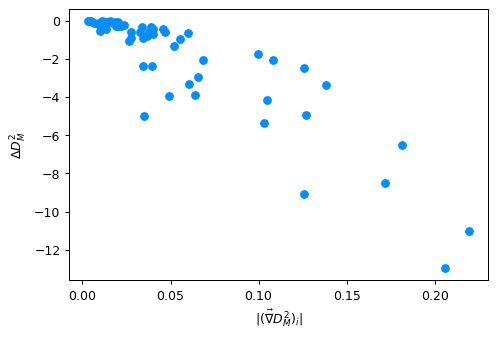

In [25]:
plt.scatter(np.abs(grad), mod_chi2 - orig_chi2)
plt.xlabel(r"$|(\vec\nabla D^2_M)_i|$")
plt.ylabel(r"$\Delta D^2_M$")

Text(0, 0.5, '$p_\\mu$ / [GeV/c]')

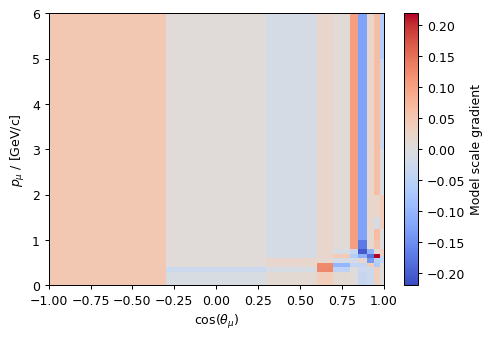

In [26]:
# Coerce matplotlib into plottin irregular 2D histograms

x_edg = costheta_edges
y_edg = set()
for edges in pmu_edges:
    y_edg.update(edges)
y_edg = list(y_edg)
y_edg.sort()

x = np.convolve(x_edg, np.ones(2) / 2, mode="valid")
y = np.convolve(y_edg, np.ones(2) / 2, mode="valid")
xx = np.broadcast_to(x, (len(y), len(x))).flatten()
yy = np.repeat(y, len(x))

data = []
for x, y in zip(xx, yy):
    for i, (x_min, x_max, y_min, y_max) in enumerate(bin_edges):
        if x_min <= x < x_max and y_min <= y < y_max:
            break
    data.append(grad[i])

absmax = np.abs(data).max()
    
# Plot it
plt.hist2d(
    xx, yy, weights=data, bins=(x_edg, y_edg), density=False, vmin=-absmax, vmax=+absmax, cmap="coolwarm"
)
plt.ylim(0.0, 6.0)
plt.colorbar(label="Model scale gradient")
plt.xlabel(r"cos($\theta_\mu$)")
plt.ylabel(r"$p_\mu$ / [GeV/c]")

Text(0, 0.5, '$p_\\mu$ / [GeV/c]')

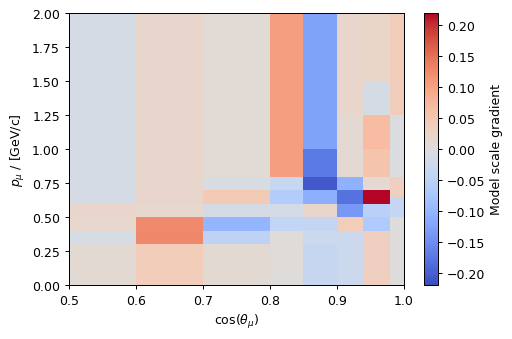

In [27]:
# Coerce matplotlib into plottin irregular 2D histograms

x_edg = costheta_edges
y_edg = set()
for edges in pmu_edges:
    y_edg.update(edges)
y_edg = list(y_edg)
y_edg.sort()

x = np.convolve(x_edg, np.ones(2) / 2, mode="valid")
y = np.convolve(y_edg, np.ones(2) / 2, mode="valid")
xx = np.broadcast_to(x, (len(y), len(x))).flatten()
yy = np.repeat(y, len(x))

data = []
for x, y in zip(xx, yy):
    for i, (x_min, x_max, y_min, y_max) in enumerate(bin_edges):
        if x_min <= x < x_max and y_min <= y < y_max:
            break
    data.append(grad[i])

absmax = np.abs(data).max()
    
# Plot it
plt.hist2d(
    xx, yy, weights=data, bins=(x_edg, y_edg), density=False, vmin=-absmax, vmax=+absmax, cmap="coolwarm"
)
plt.ylim(0.0, 2.0)
plt.xlim(0.5, 1.0)
plt.colorbar(label="Model scale gradient")
plt.xlabel(r"cos($\theta_\mu$)")
plt.ylabel(r"$p_\mu$ / [GeV/c]")

Text(0, 0.5, '$p_\\mu$ / [GeV/c]')

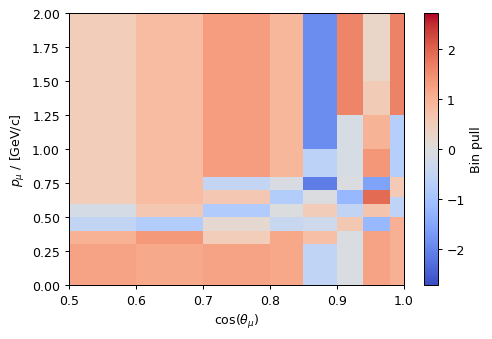

In [28]:
# Coerce matplotlib into plottin irregular 2D histograms

x_edg = costheta_edges
y_edg = set()
for edges in pmu_edges:
    y_edg.update(edges)
y_edg = list(y_edg)
y_edg.sort()

x = np.convolve(x_edg, np.ones(2) / 2, mode="valid")
y = np.convolve(y_edg, np.ones(2) / 2, mode="valid")
xx = np.broadcast_to(x, (len(y), len(x))).flatten()
yy = np.repeat(y, len(x))

data = []
for x, y in zip(xx, yy):
    for i, (x_min, x_max, y_min, y_max) in enumerate(bin_edges):
        if x_min <= x < x_max and y_min <= y < y_max:
            break
    data.append((unfolded_h[0][i] - post_fit_h[0][i]) / np.sqrt(cov_unfolded[i,i]))

absmax = np.abs(data).max()
    
# Plot it
plt.hist2d(
    xx, yy, weights=data, bins=(x_edg, y_edg), density=False, vmin=-absmax, vmax=+absmax, cmap="coolwarm"
)
plt.ylim(0.0, 2.0)
plt.xlim(0.5, 1.0)
plt.colorbar(label="Bin pull")
plt.xlabel(r"cos($\theta_\mu$)")
plt.ylabel(r"$p_\mu$ / [GeV/c]")

Text(0, 0.5, '$p_\\mu$ / [GeV/c]')

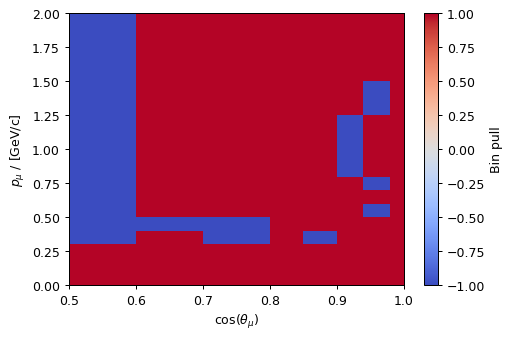

In [29]:
# Coerce matplotlib into plottin irregular 2D histograms

x_edg = costheta_edges
y_edg = set()
for edges in pmu_edges:
    y_edg.update(edges)
y_edg = list(y_edg)
y_edg.sort()

x = np.convolve(x_edg, np.ones(2) / 2, mode="valid")
y = np.convolve(y_edg, np.ones(2) / 2, mode="valid")
xx = np.broadcast_to(x, (len(y), len(x))).flatten()
yy = np.repeat(y, len(x))

data = []
for x, y in zip(xx, yy):
    for i, (x_min, x_max, y_min, y_max) in enumerate(bin_edges):
        if x_min <= x < x_max and y_min <= y < y_max:
            break
    data.append((unfolded_h[0][i] - post_fit_h[0][i]) * grad[i])

data /= np.abs(data)

absmax = np.abs(data).max()
    
# Plot it
plt.hist2d(
    xx, yy, weights=data, bins=(x_edg, y_edg), density=False, vmin=-absmax, vmax=+absmax, cmap="coolwarm"
)
plt.ylim(0.0, 2.0)
plt.xlim(0.5, 1.0)
plt.colorbar(label="Bin pull")
plt.xlabel(r"cos($\theta_\mu$)")
plt.ylabel(r"$p_\mu$ / [GeV/c]")